In [25]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']


** Use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to smooth the series(get rid of peaks in Monday and Friday). I use rolling window of 15 and power of 3 **

In [3]:
##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()


,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year
2009-12-01,0.100098,0.061363,0.153196,0.271778,0.687016,1.160258,2.054386,2.757788,3.284833,4.120350,4.238709
2009-12-02,0.086674,0.056951,0.154331,0.284103,0.716897,1.195020,2.092698,2.809209,3.335632,4.177983,4.290404
2009-12-03,0.073826,0.052056,0.155113,0.295601,0.741628,1.222619,2.124901,2.851474,3.378137,4.225860,4.334141
2009-12-04,0.061699,0.047002,0.155626,0.306321,0.761818,1.244129,2.151963,2.885915,3.413430,4.265017,4.370661
2009-12-07,0.050435,0.042114,0.155952,0.316311,0.778075,1.260623,2.174851,2.913866,3.442595,4.296487,4.400707


**Define a rolling window function that calculate following statistic for one column:**  
1.Mean  
2.Standard Deviation  
3.Median  
4.Min  
5.Max  
6.Rooted Mean Square  
7.[Crest Factor](https://en.wikipedia.org/wiki/Crest_factor)  
8.[Zero-crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate)(here is Mean-crossing Rate)  
9.Trend(Slope of linear regression)

In [4]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [6]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(10)
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,1-year,2-year,3-year,5-year,7-year,10-year,20-year,30-year,Day of week,IS_WEEKEND
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.26,0.67,1.14,2.03,2.74,3.28,4.14,4.26,1,0
2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.28,0.72,1.19,2.09,2.8,3.32,4.14,4.26,2,0
2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.3,0.74,1.23,2.14,2.87,3.39,4.23,4.33,3,0
2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.36,0.84,1.34,2.24,2.97,3.48,4.31,4.4,4,0
2009-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.32,0.78,1.26,2.19,2.92,3.44,4.29,4.4,0,0


In [7]:
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)

In [8]:
yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,3-month_10,6-month_10,1-year_10,2-year_10,3-year_10,5-year_10,7-year_10,10-year_10,20-year_10,30-year_10
2010-01-14,0.022769,0.004435,0.022860,0.018290,0.027158,0.017537,0.005568,0.014833,0.012579,0.027158,...,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.8,4.54,4.61
2010-01-15,0.026842,0.003833,0.027158,0.022860,0.030507,0.019903,0.007096,0.018290,0.012579,0.030507,...,0.06,0.2,0.47,1.14,1.7,2.69,3.39,3.85,4.58,4.63
2010-01-19,0.029729,0.002283,0.030507,0.027158,0.031520,0.022535,0.007552,0.022860,0.012579,0.031520,...,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.6,4.65
2010-01-20,0.031173,0.000578,0.031493,0.030507,0.031520,0.025237,0.006736,0.027158,0.014833,0.031520,...,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-21,0.031116,0.000677,0.031493,0.030335,0.031520,0.027452,0.005093,0.030335,0.018290,0.031520,...,0.06,0.15,0.4,1.01,1.6,2.6,3.33,3.85,4.63,4.7


In [15]:
#print(yield_data_features.shape)
target = '30-year'
Y=yield_data_features[[target]]
Y.shape
X=yield_data_features.drop(target,axis=1)
X.shape
#TrainData = yield_data[yield_data.index < '2017-09-01']
#TestData = yield_data[yield_data.index >= '2017-08-01']

X_train=X[X.index < '2017-09-01']
X_test=X[X.index >= '2017-09-01']
y_train=Y[Y.index < '2017-09-01']
y_test=Y[Y.index  >= '2017-09-01']

In [26]:
max_depth = 30
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
y_rf = regr_rf.predict(X_test)

#score
print(r2_score(y_test,y_rf))
print(np.sqrt(mean_squared_error(y_test,y_rf)))

/Users/lakshyagarg/Downloads/ENTER/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.5704492799
0.0308134806251


In [33]:
range(len(y_test))

range(0, 17)

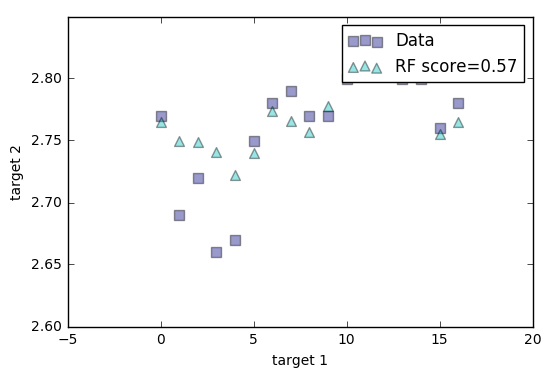

In [37]:
#pd.concat([pd.DataFrame(y_rf).reset_index(drop=True),y_test.reset_index(drop=True)],axis=1)
# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(range(len(y_test)), y_test, edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(range(len(y_rf)), y_rf, edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))
#plt.xlim([-6, 6])
#plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.legend()
plt.show()